In [1]:
import numpy as np
import pystellibs
from dev.base import PhotometryPipeline
from dev.star_cluster import StarCluster
from dev.parsec_isochrones import Parsec
from dev.photometry import Photometry
from dev.extinction_handler import DustAttenuator
from dev.spectral_interpolator import SpectrumGenerator
from dev.distance import Distance
import matplotlib.pyplot as plt

In [2]:
parsec_folder_path = '/Users/ratzenboe/Documents/work/code/SimpleSimulator/simulator/isochrone_files/gaia_phot/'
star_cluster_kwargs = dict(
    mu=np.array([1000, 0, 0, 10, 10, 10]),
    cov=np.diag([1, 1, 1, 1, 1, 1]),
    cluster_mass=1e3,
    logAge=6.0,
    Z=0.0125
)

phpipe = PhotometryPipeline(steps=[
    ('cluster', StarCluster(**star_cluster_kwargs)),
    ('parsec_isochrones', Parsec(parsec_folder_path)),
    # BT-Settl and BaSeL models seem to reproduce more or less the Parsec isochrone model results.
    # The BaSeL models seem to approximate the behavior better at the redder, faint end
    ('spectrum', SpectrumGenerator(stellib=pystellibs.BaSeL())),
    ('dust', DustAttenuator(law='fitzpatrick')),
    ('distance', Distance()),
    ('filter', Photometry(filter_names=["GAIA/GAIA3.Gbp", "GAIA/GAIA3.G", "GAIA/GAIA3.Grp", '2mass', 'irac']))
])

PARSEC isochrones read and processed!


In [3]:
data = dict(Av=0)
data = phpipe.run(data)

Total cluster mass is 999.036 (limit was 1000)


/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_27918/4100520745.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cl.magnitude, flx.magnitude[idx], s=100, marker='x', c=colors[i], label=f'{b}', lw=3, alpha=1, zorder=10)


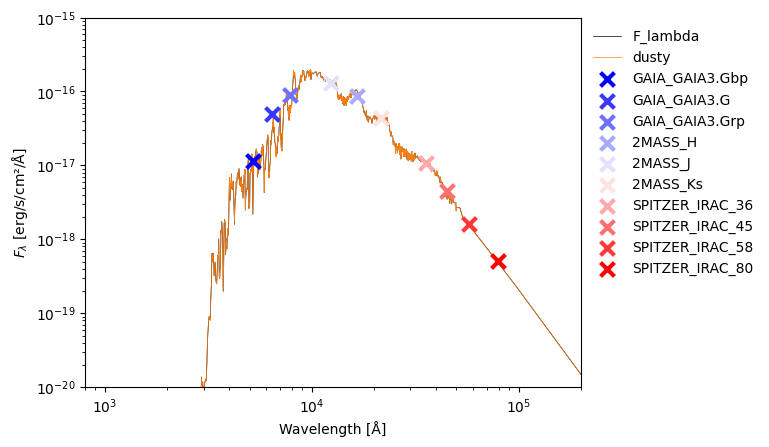

In [4]:
idx = 0

plt.loglog(data['wavelength'].magnitude, data['flam'].magnitude[idx], lw=0.5, label='F_lambda', color='k')
plt.loglog(data['wavelength'].magnitude, data['flam_dust'].magnitude[idx], lw=0.5, label='dusty', color='tab:orange')

# create 10 different colors
colors = plt.cm.bwr(np.linspace(0, 1, len(data['flam_band'])))

for i, (b, flx) in enumerate(data['flam_band'].items()):
    cl = data['cl_band'][b]
    # Plot the band
    plt.scatter(cl.magnitude, flx.magnitude[idx], s=100, marker='x', c=colors[i], label=f'{b}', lw=3, alpha=1, zorder=10)
    # Compute the magnitudes


plt.xlim(800, 2e5)
plt.ylim(1e-20, 1e-15)
plt.xlabel('Wavelength [Å]')
plt.ylabel(r'$F_{\lambda}$ [erg/s/cm²/Å]')
# put legend outside
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

# Plot CMD

In [5]:
# Compute CMD
is_alive = (data['lifetime_logAge'] > data['logAge'])[data['isin_param_range']]
gaia_bp = data['mag_band']['GAIA_GAIA3.Gbp'][is_alive]
gaia_rp = data['mag_band']['GAIA_GAIA3.Grp'][is_alive]
gaia_g = data['mag_band']['GAIA_GAIA3.G'][is_alive]
d_pc = data['distance'][data['isin_param_range']][is_alive]

In [6]:
# Compute absolute G magnitude
M_G = gaia_g - 5 * np.log10(d_pc/10)
bp_rp = gaia_bp - gaia_rp

Text(0, 0.5, 'M_G')

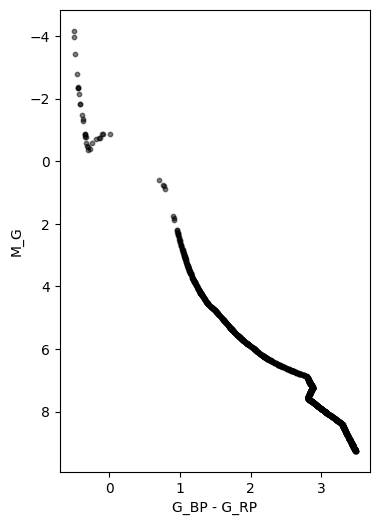

In [7]:
plt.figure(figsize=(4, 6))
plt.scatter(bp_rp, M_G, s=10, c='k', alpha=0.5)
# invert y axis
plt.gca().invert_yaxis()
plt.xlabel('G_BP - G_RP')
plt.ylabel('M_G')

# Test against Parsec isochrones

In [8]:
# Test against Parsec isochrones
# Add path to isochrone scripts
import os
import sys
sys.path.append('/Users/ratzenboe/Documents/work/code/SimpleSimulator/simulator/modules')
from isochrone_base import ParsecGaia
p_gaia_obj = ParsecGaia(parsec_folder_path)
df_p_gaia = p_gaia_obj.query_cmd(
    data['mass'], data['logAge'], np.ones_like(data['mass'])*phpipe.get_step('parsec_isochrones').feh_from_z(0.0125)
)
m_G = df_p_gaia.M_G + 5 * np.log10(data['distance']) - 5

PARSEC isochrones read and processed!


Text(0, 0.5, 'M_G')

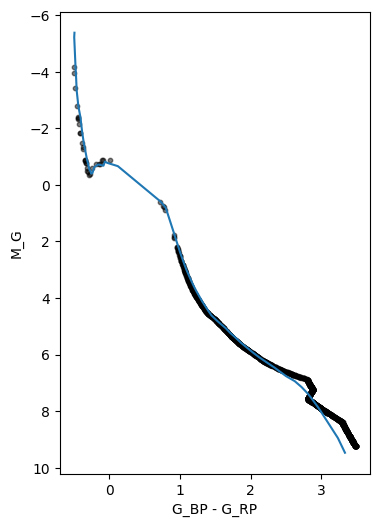

In [9]:
plt.figure(figsize=(4, 6))
plt.scatter(bp_rp, M_G, s=10, c='k', alpha=0.5)
plt.plot(df_p_gaia.G_BP - df_p_gaia.G_RP, df_p_gaia.M_G)
# invert y axis
plt.gca().invert_yaxis()
plt.xlabel('G_BP - G_RP')
plt.ylabel('M_G')

(-0.6, 0.6)

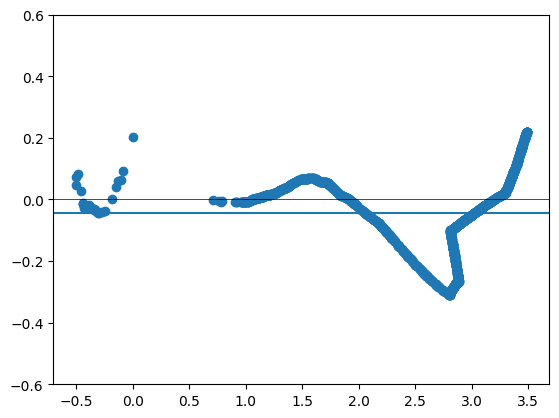

In [10]:
plt.scatter(bp_rp, df_p_gaia.M_G.values[data['isin_param_range']][is_alive] - M_G)
# compute mean distance modulus
plt.axhline(np.mean(m_G[data['isin_param_range']][is_alive] - gaia_g))
plt.axhline(0, color='k', lw=0.5)
plt.ylim((-0.6, 0.6))

In [11]:
np.mean(df_p_gaia.M_G.values[data['isin_param_range']][is_alive] - M_G)

-0.04357993745191455